# Tutorial: Transfer Learning with EfficientNet
## 1) Import Libraries

- This tutorial is tested with tensorflow 2.1 gpu
- EfficientNetB0 comes from keras_applications.efficientnet

In [1]:
from pathlib import Path

from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from keras_preprocessing.image import ImageDataGenerator
from keras_applications.efficientnet import EfficientNetB0

import tensorflow as tf
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
%matplotlib inline

## 2) Download dataset, and set directory paths
- Image dataset comes from https://github.com/fastai/imagenette
- The 320 px dataset is used here
- Download link: https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz

In [2]:
current_dir = Path().absolute()

train_dir = current_dir/'data/imagenette2-320/train'
val_dir = current_dir/'data/imagenette2-320/val'

## 3) Create image data generators
- If GPU runs out of memory, consider changing batch_size (e.g. batch_size = 16)

In [3]:
batch_size=32
num_classes=10
input_shape = (224, 224, 3)

# Normalize images
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_it = train_datagen.flow_from_directory(train_dir, target_size=input_shape[:2], shuffle=True, class_mode='categorical', batch_size=batch_size)
val_it = val_datagen.flow_from_directory(val_dir, target_size=input_shape[:2], shuffle=True, class_mode='categorical', batch_size=batch_size)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## 4) Create base model from EfficientNetB0
- We will fine tune EfficientNet to our dataset -> include_top = False

In [4]:
kwargs = {'backend': tf.keras.backend, 'layers': tf.keras.layers,
          'models': tf.keras.models, 'utils': tf.keras.utils}

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape, **kwargs)

## 5) Add some top layers, make base model untrainable, compile

In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

new_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
new_model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         stem_conv_pad[0][0]              
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
______________________________________________________________________________________________

## 6) Train/fit model to dataset

In [6]:
num_epochs = 5

history = new_model.fit(train_it, validation_data = val_it, epochs=num_epochs, verbose = 1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 296 steps, validate for 123 steps
Epoch 1/5
296/296 [==============================] - 83s 279ms/step - loss: 0.3098 - accuracy: 0.9354 - val_loss: 0.0925 - val_accuracy: 0.9786
Epoch 2/5
296/296 [==============================] - 60s 204ms/step - loss: 0.0836 - accuracy: 0.9781 - val_loss: 0.0670 - val_accuracy: 0.9829
Epoch 3/5
296/296 [==============================] - 61s 206ms/step - loss: 0.0622 - accuracy: 0.9837 - val_loss: 0.0586 - val_accuracy: 0.9811
Epoch 4/5
296/296 [==============================] - 62s 208ms/step - loss: 0.0483 - accuracy: 0.9867 - val_loss: 0.0541 - val_accuracy: 0.9845
Epoch 5/5
296/296 [==============================] - 62s 209ms/step - loss: 0.0369 - accuracy: 0.9917 - val_loss: 0.0523 - val_accuracy: 0.9839


## 7) Plot Training/Validation History

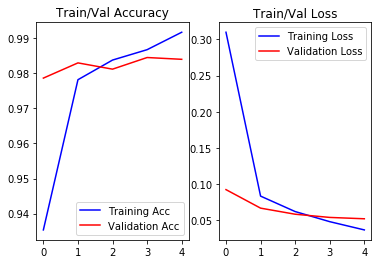

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Train/Val Loss')
plt.legend()

plt.show()